# Financial Well-Being Project: Data Analysis

Survey was administered by the Consumer Financial Protection Bureau (CFPB)

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

# Preparing and scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine learning models and optimizers
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Metrics for model evaluation
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report

## Load Preprocessed Data

In [2]:
# Set path for CSV file
path = Path('data/fwb_processed_data_2.csv')
# path = Path('resources/NFWBS_PUF_2016_data.csv')

# Load preprocessed data
data_df = pd.read_csv(path, index_col=0)

# Display shape and sample data
print(f'Dataframe shape: {data_df.shape}')
data_df.head()

Dataframe shape: (5931, 114)


PPEDUC  agecat  HEALTH  PPGENDER  HOUSESAT  KIDS_1  KIDS_2  KIDS_3  \
PUF_ID                                                                       
10350        4       8       2         1         4       0       0       0   
7740         2       3       3         1         3       0       0       0   
13699        3       3       3         1         3       0       0       0   
7375         2       2       3         1         3       0       0       0   
10910        4       2       5         1         4       0       0       0   

        KIDS_3.1  fpl  ...  PPREG4_4  PPREG9_1  PPREG9_2  PPREG9_3  PPREG9_4  \
PUF_ID                 ...                                                     
10350          0    3  ...         1         0         0         0         0   
7740           0    3  ...         0         0         0         1         0   
13699          0    3  ...         1         0         0         0         0   
7375           0    3  ...         0         0         0         0         1   
10910          0    3  ...         0         0         0         1         0   

        PPREG9_5  PPREG9_6  PPREG9_7  PPREG9_8  PPREG9_9  
PUF_ID                                                    
10350          0         0         0         1         0  
7740           0         0         0         0         0  
13699          0         0         0         0         1  
7375           0         0         0         0         0  
10910          0         0         0         0         0  

[5 rows x 114 columns]

## Model Definitions and Functions

In [3]:
# Define features set
X = data_df.copy()
X.drop(columns=['FWBscore', 'FWBscore_wt'], axis=1, inplace=True)
X.head()

PPEDUC  agecat  HEALTH  PPGENDER  HOUSESAT  KIDS_1  KIDS_2  KIDS_3  \
PUF_ID                                                                       
10350        4       8       2         1         4       0       0       0   
7740         2       3       3         1         3       0       0       0   
13699        3       3       3         1         3       0       0       0   
7375         2       2       3         1         3       0       0       0   
10910        4       2       5         1         4       0       0       0   

        KIDS_3.1  fpl  ...  PPREG4_4  PPREG9_1  PPREG9_2  PPREG9_3  PPREG9_4  \
PUF_ID                 ...                                                     
10350          0    3  ...         1         0         0         0         0   
7740           0    3  ...         0         0         0         1         0   
13699          0    3  ...         1         0         0         0         0   
7375           0    3  ...         0         0         0         0         1   
10910          0    3  ...         0         0         0         1         0   

        PPREG9_5  PPREG9_6  PPREG9_7  PPREG9_8  PPREG9_9  
PUF_ID                                                    
10350          0         0         0         1         0  
7740           0         0         0         0         0  
13699          0         0         0         0         1  
7375           0         0         0         0         0  
10910          0         0         0         0         0  

[5 rows x 112 columns]

In [4]:
# Define target
y = data_df['FWBscore'].values.reshape(-1, 1)
y[:5]

array([[55],
       [51],
       [49],
       [49],
       [67]], dtype=int64)

In [5]:
# Function to evaluate model using confusion matrix and classification report
def eval_model_cmcr():
    # Calculating the confusion matrix
    index = ['Actual ' + label for label in class_labels]
    columns = ['Predicted ' + label for label in class_labels]

    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=index,
        columns=columns
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print("Confusion Matrix")
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    return round(acc_score, 3)

In [6]:
# Function to split up and classify target based on percentiles
def classify_y(num, labels):
    y = pd.qcut(data_df['FWBscore'], num, labels=labels)
    y = y.ravel()
    print(y[:5])
    return y

In [7]:
# Function to plot a decision tree
def plot_d_tree(model, acc_score, i, num_classes, figsize):
    
    # Configure plot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=600)
    
    # Plot tree
    plot_tree(model, feature_names=feature_names, class_names=class_labels, filled=True)
    title = f'Decision Tree Model #{i+1} with {num_classes} Classes\nAccuracy Score:{acc_score}'
    axes.set_title(title, fontsize = 11)
    
    # Save tree
    plt.savefig(f'images/dataset_1/dt_{num_classes}c_{i+1}.png')

In [8]:
# Function to plot first 4 trees in a random forest
# Code ref: https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn
def plot_r_forest(model, acc_score, i, num_classes, figsize):
    
    # Configure plot
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=figsize, dpi=600)
    for index in range(0, 4):
        plot_tree(model.estimators_[index],
                       feature_names = feature_names, 
                       class_names=class_labels,
                       filled = True,
                       ax = axes[index])
        if i == 0:
            title = f'Randon Forest Model #{i+1} with {num_classes} Classes\nEstimator: {index}, Accuracy Score:{acc_score}'
        else:
            title = f'Estimator: {index}'
        axes[i].set_title(title, fontsize = 11)
    
    # Save tree
    plt.savefig(f'images/dataseet_1/rf_{num_classes}c_{i+1}.png')

## Linear Regression Model

In [9]:
# Create a model with scikit-learn
model_lr = LinearRegression()

### Fit the model and make predictions

In [10]:
# Fit the data into the model
model_lr.fit(X, y)

LinearRegression()

In [11]:
# Make predictions using the X set
predicted_y_values = model_lr.predict(X)

# Create a copy of the original data
predicted_df = data_df.copy()

# Add a column with the predicted salary values
predicted_df["predicted_FWBscore"] = predicted_y_values

# Display sample data
predicted_df

PPEDUC  agecat  HEALTH  PPGENDER  HOUSESAT  KIDS_1  KIDS_2  KIDS_3  \
PUF_ID                                                                       
10350        4       8       2         1         4       0       0       0   
7740         2       3       3         1         3       0       0       0   
13699        3       3       3         1         3       0       0       0   
7375         2       2       3         1         3       0       0       0   
10910        4       2       5         1         4       0       0       0   
...        ...     ...     ...       ...       ...     ...     ...     ...   
11220        5       7       5         2         4       0       0       1   
13118        2       6       4         1         4       1       0       2   
8709         5       2       3         2         3       0       0       0   
8515         2       2       3         1         3       2       0       0   
8516         5       3       5         1         3       0       2       0   

        KIDS_3.1  fpl  ...  PPREG9_1  PPREG9_2  PPREG9_3  PPREG9_4  PPREG9_5  \
PUF_ID                 ...                                                     
10350          0    3  ...         0         0         0         0         0   
7740           0    3  ...         0         0         1         0         0   
13699          0    3  ...         0         0         0         0         0   
7375           0    3  ...         0         0         0         1         0   
10910          0    3  ...         0         0         1         0         0   
...          ...  ...  ...       ...       ...       ...       ...       ...   
11220          1    3  ...         0         0         1         0         0   
13118          2    2  ...         0         0         0         0         0   
8709           0    3  ...         0         1         0         0         0   
8515           0    3  ...         0         0         0         0         0   
8516           0    2  ...         0         0         0         0         1   

        PPREG9_6  PPREG9_7  PPREG9_8  PPREG9_9  predicted_FWBscore  
PUF_ID                                                              
10350          0         0         1         0           59.619385  
7740           0         0         0         0           55.770264  
13699          0         0         0         1           50.502197  
7375           0         0         0         0           50.609863  
10910          0         0         0         0           61.085693  
...          ...       ...       ...       ...                 ...  
11220          0         0         0         0           66.705566  
13118          1         0         0         0           68.629150  
8709           0         0         0         0           57.636963  
8515           0         0         0         1           46.335938  
8516           0         0         0         0           51.659424  

[5931 rows x 115 columns]

### Evaluate the model

In [12]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
score = model_lr.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The score is 0.54151049872597.
The r2 is 0.54151049872597.
The mean squared error is 89.49290576068171.
The root mean squared error is 9.460069014583441.
The standard deviation is 13.971068018615613.


## Decision Tree with 2 Target Classes

### Setup and scale data

In [13]:
# Display quartiles for cutting
data_df['FWBscore'].quantile([.25, .5, .75])

0.25    48.0
0.50    56.0
0.75    65.0
Name: FWBscore, dtype: float64

In [14]:
# Create 2 target classes
num_classes = 2
class_labels = ['Bad', 'Good']
y = classify_y(num_classes, class_labels)

['Bad', 'Bad', 'Bad', 'Bad', 'Good']
Categories (2, object): ['Bad' < 'Good']


In [15]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Determine the best set of hyperparameters

In [16]:
# Set possible values for hyperparameters
parameters = {'max_depth': (3, 5, 7, 9, 10, 20, 50),
              'criterion': ('gini', 'entropy'),
              'max_features': ('sqrt', 'log2', None),
              'min_samples_split': (2, 4, 6, 10, 20, 30),
              'min_samples_leaf': (1, 2, 5, 8) 
             }

In [17]:
# Create the decision tree classifier instance
model_dt = RandomizedSearchCV(DecisionTreeClassifier(),param_distributions = parameters, cv = 20, verbose = True)

In [18]:
# Fit the model
model_dt = model_dt.fit(X_train, y_train)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [19]:
model_dt.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=10)

### Fit, Predict and Evaluate Model

In [20]:
# Create list to store decision tree classifier instances
model_dt2c = []

# DT Model #1: Default settings
model_dt2c.append(DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_split=2, min_samples_leaf=1))

# DT Model #1: Simple tree
model_dt2c.append(DecisionTreeClassifier(max_depth=4, max_features=None, min_samples_split=5, min_samples_leaf=3))  

# DT Model #3: Best results after testing
model_dt2c.append(DecisionTreeClassifier(max_depth=5, max_features=None, min_samples_split=10, min_samples_leaf=5))                 
                  
# DT Model #4: One of the best estimators from RandomizedSearchCV
model_dt2c.append(DecisionTreeClassifier(max_depth=7, max_features=None, min_samples_split=4, min_samples_leaf=5))

In [21]:
# Create list to store accurancy scores
acc_score_dt2c = []

# Loop to Fit, predict and evaluate models
for i in range(0, len(model_dt2c)):
    model = model_dt2c[i]           
               
    # Fit the model
    model = model.fit(X_train, y_train)

    # Make predictions using the testing data
    predictions = model.predict(X_test)
    
    # Evaluate the model and store accuracy score
    print(f'Evaluation of Model #{i+1}\n')
    acc_score = eval_model_cmcr()
    acc_score_dt2c.append(acc_score)

Evaluation of Model #1

Confusion Matrix


Predicted Bad  Predicted Good
Actual Bad             496             263
Actual Good            241             483

Accuracy Score : 0.6601483479433581
Classification Report
              precision    recall  f1-score   support

         Bad       0.67      0.65      0.66       759
        Good       0.65      0.67      0.66       724

    accuracy                           0.66      1483
   macro avg       0.66      0.66      0.66      1483
weighted avg       0.66      0.66      0.66      1483

Evaluation of Model #2

Confusion Matrix


Predicted Bad  Predicted Good
Actual Bad             492             267
Actual Good            183             541

Accuracy Score : 0.6965610249494268
Classification Report
              precision    recall  f1-score   support

         Bad       0.73      0.65      0.69       759
        Good       0.67      0.75      0.71       724

    accuracy                           0.70      1483
   macro avg       0.70      0.70      0.70      1483
weighted avg       0.70      0.70      0.70      1483

Evaluation of Model #3

Confusion Matrix


Predicted Bad  Predicted Good
Actual Bad             501             258
Actual Good            169             555

Accuracy Score : 0.7120701281186783
Classification Report
              precision    recall  f1-score   support

         Bad       0.75      0.66      0.70       759
        Good       0.68      0.77      0.72       724

    accuracy                           0.71      1483
   macro avg       0.72      0.71      0.71      1483
weighted avg       0.72      0.71      0.71      1483

Evaluation of Model #4

Confusion Matrix


Predicted Bad  Predicted Good
Actual Bad             563             196
Actual Good            239             485

Accuracy Score : 0.7066756574511126
Classification Report
              precision    recall  f1-score   support

         Bad       0.70      0.74      0.72       759
        Good       0.71      0.67      0.69       724

    accuracy                           0.71      1483
   macro avg       0.71      0.71      0.71      1483
weighted avg       0.71      0.71      0.71      1483



### Plot and Save Decision Trees

In [22]:
feature_names = list(X.columns)
figsize = (15,5)

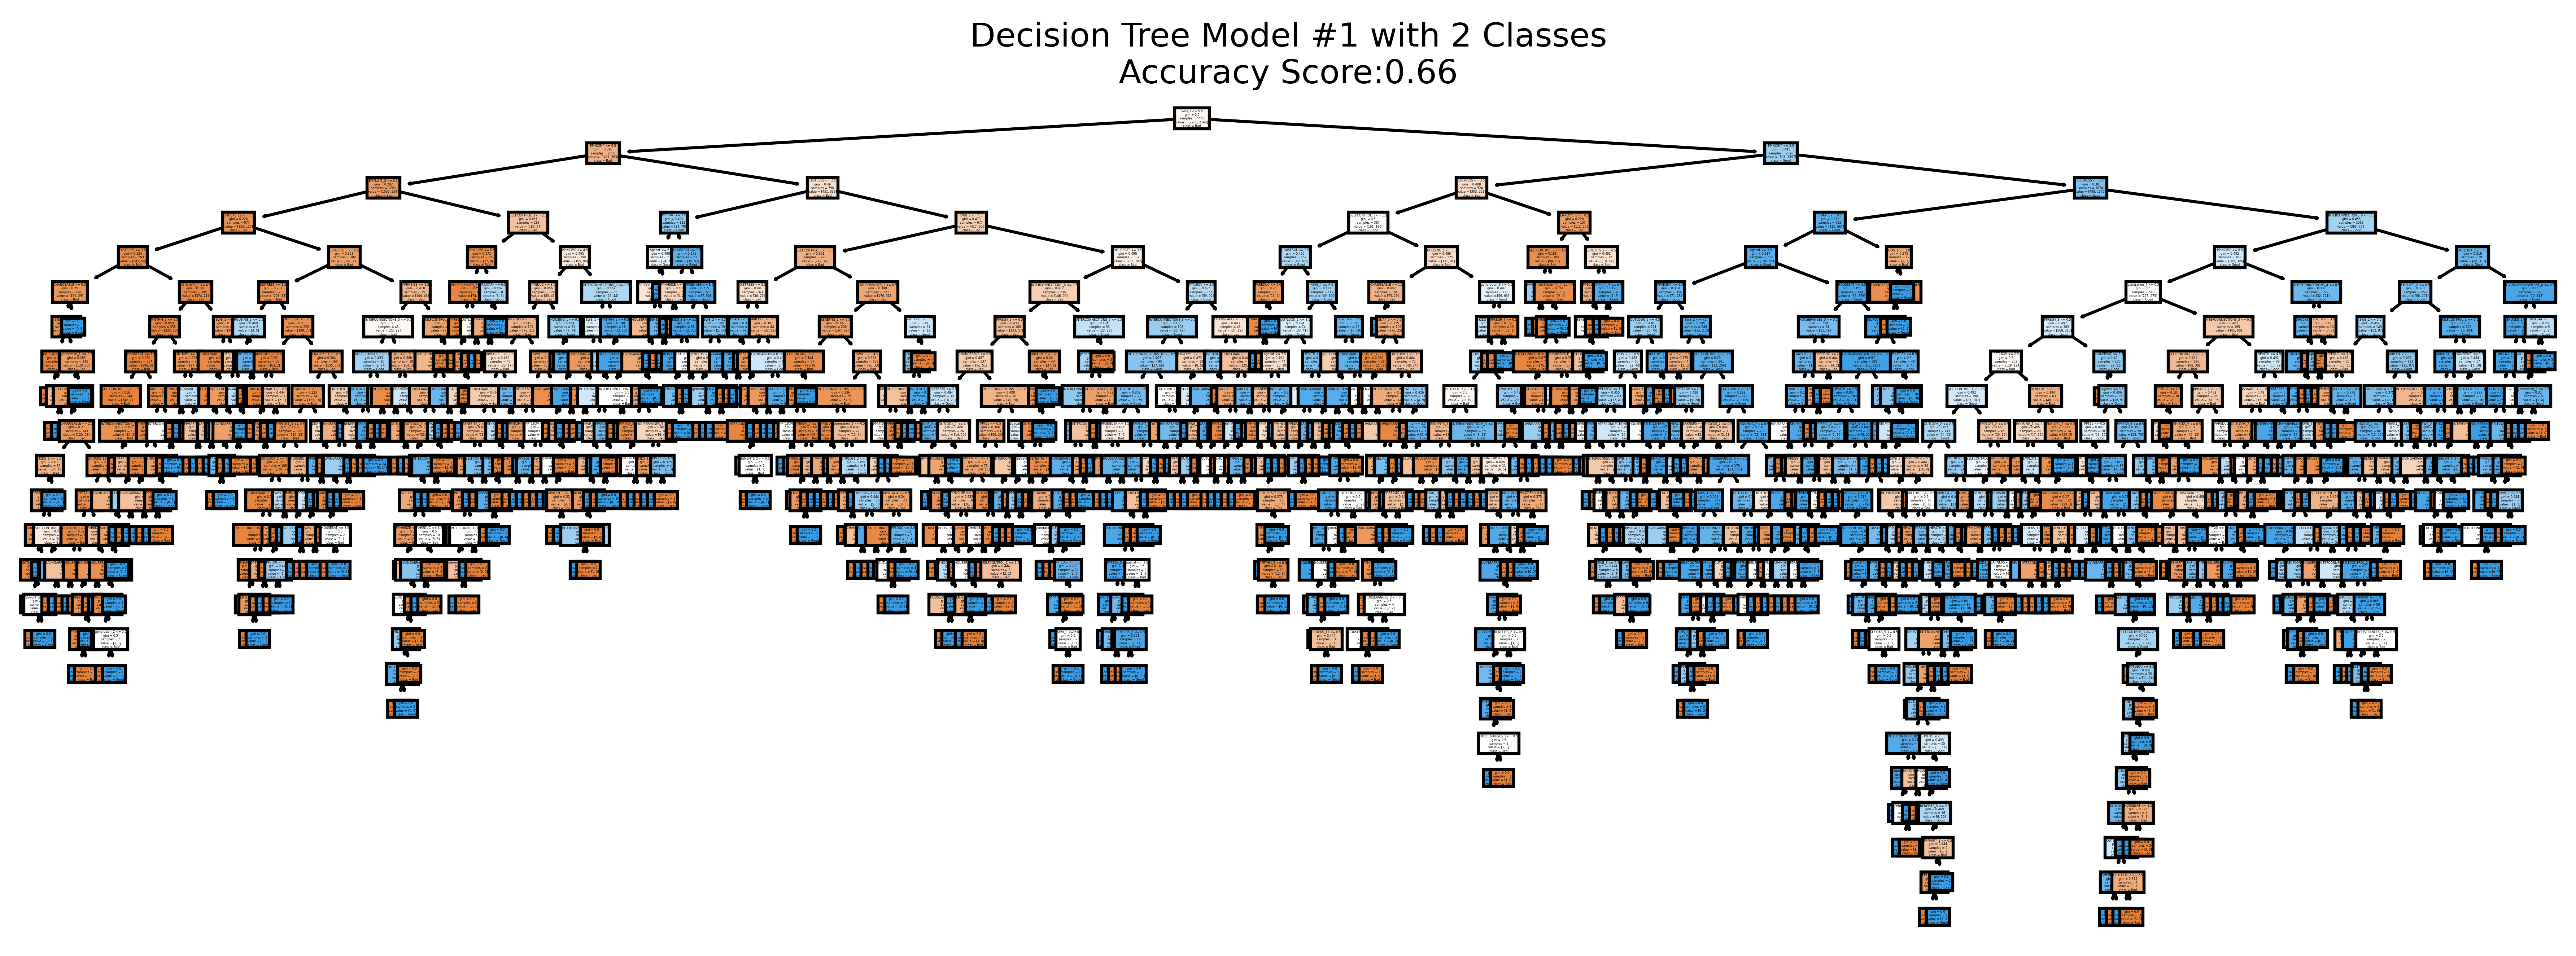

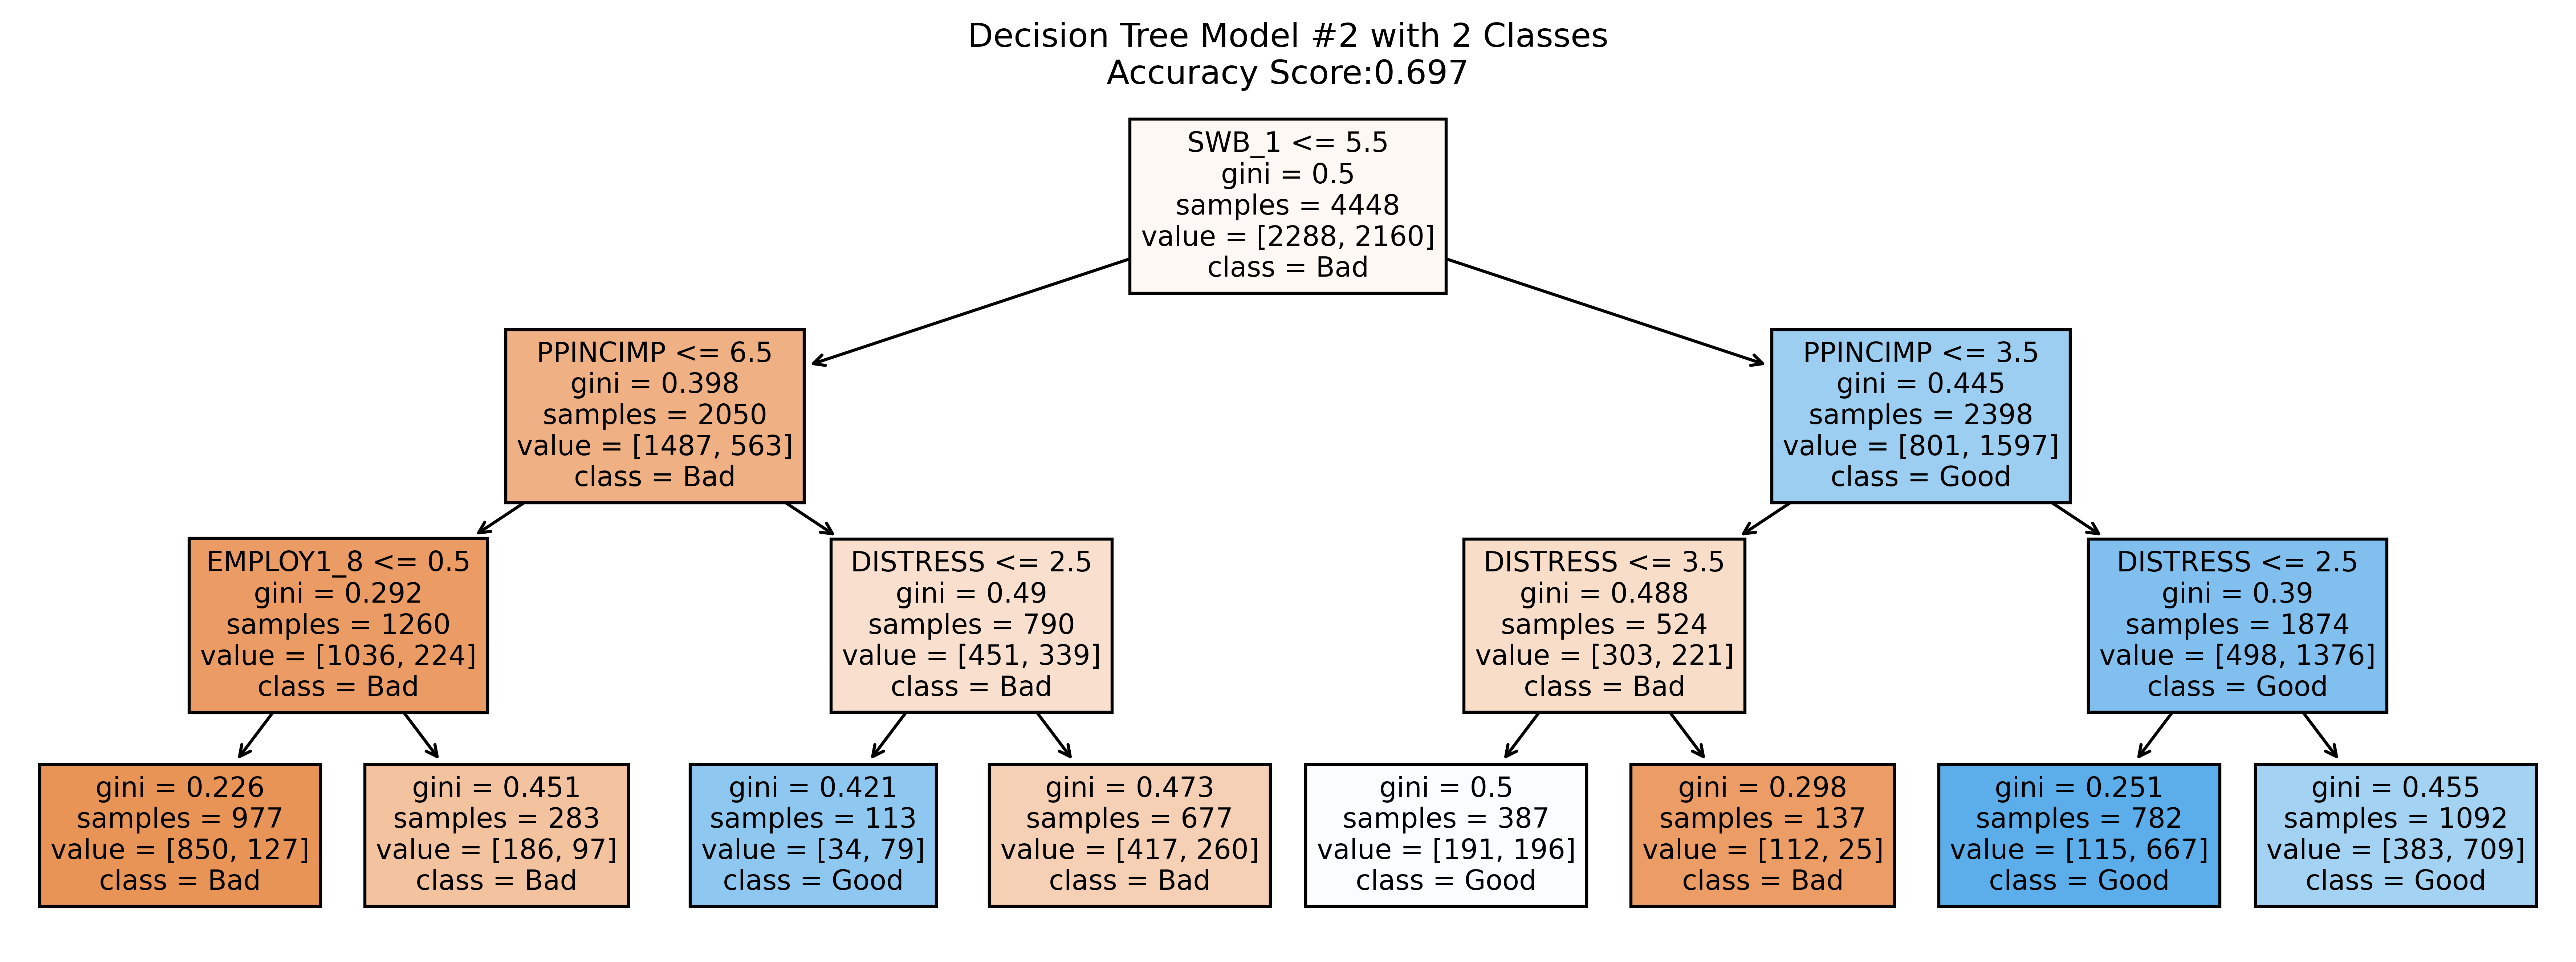

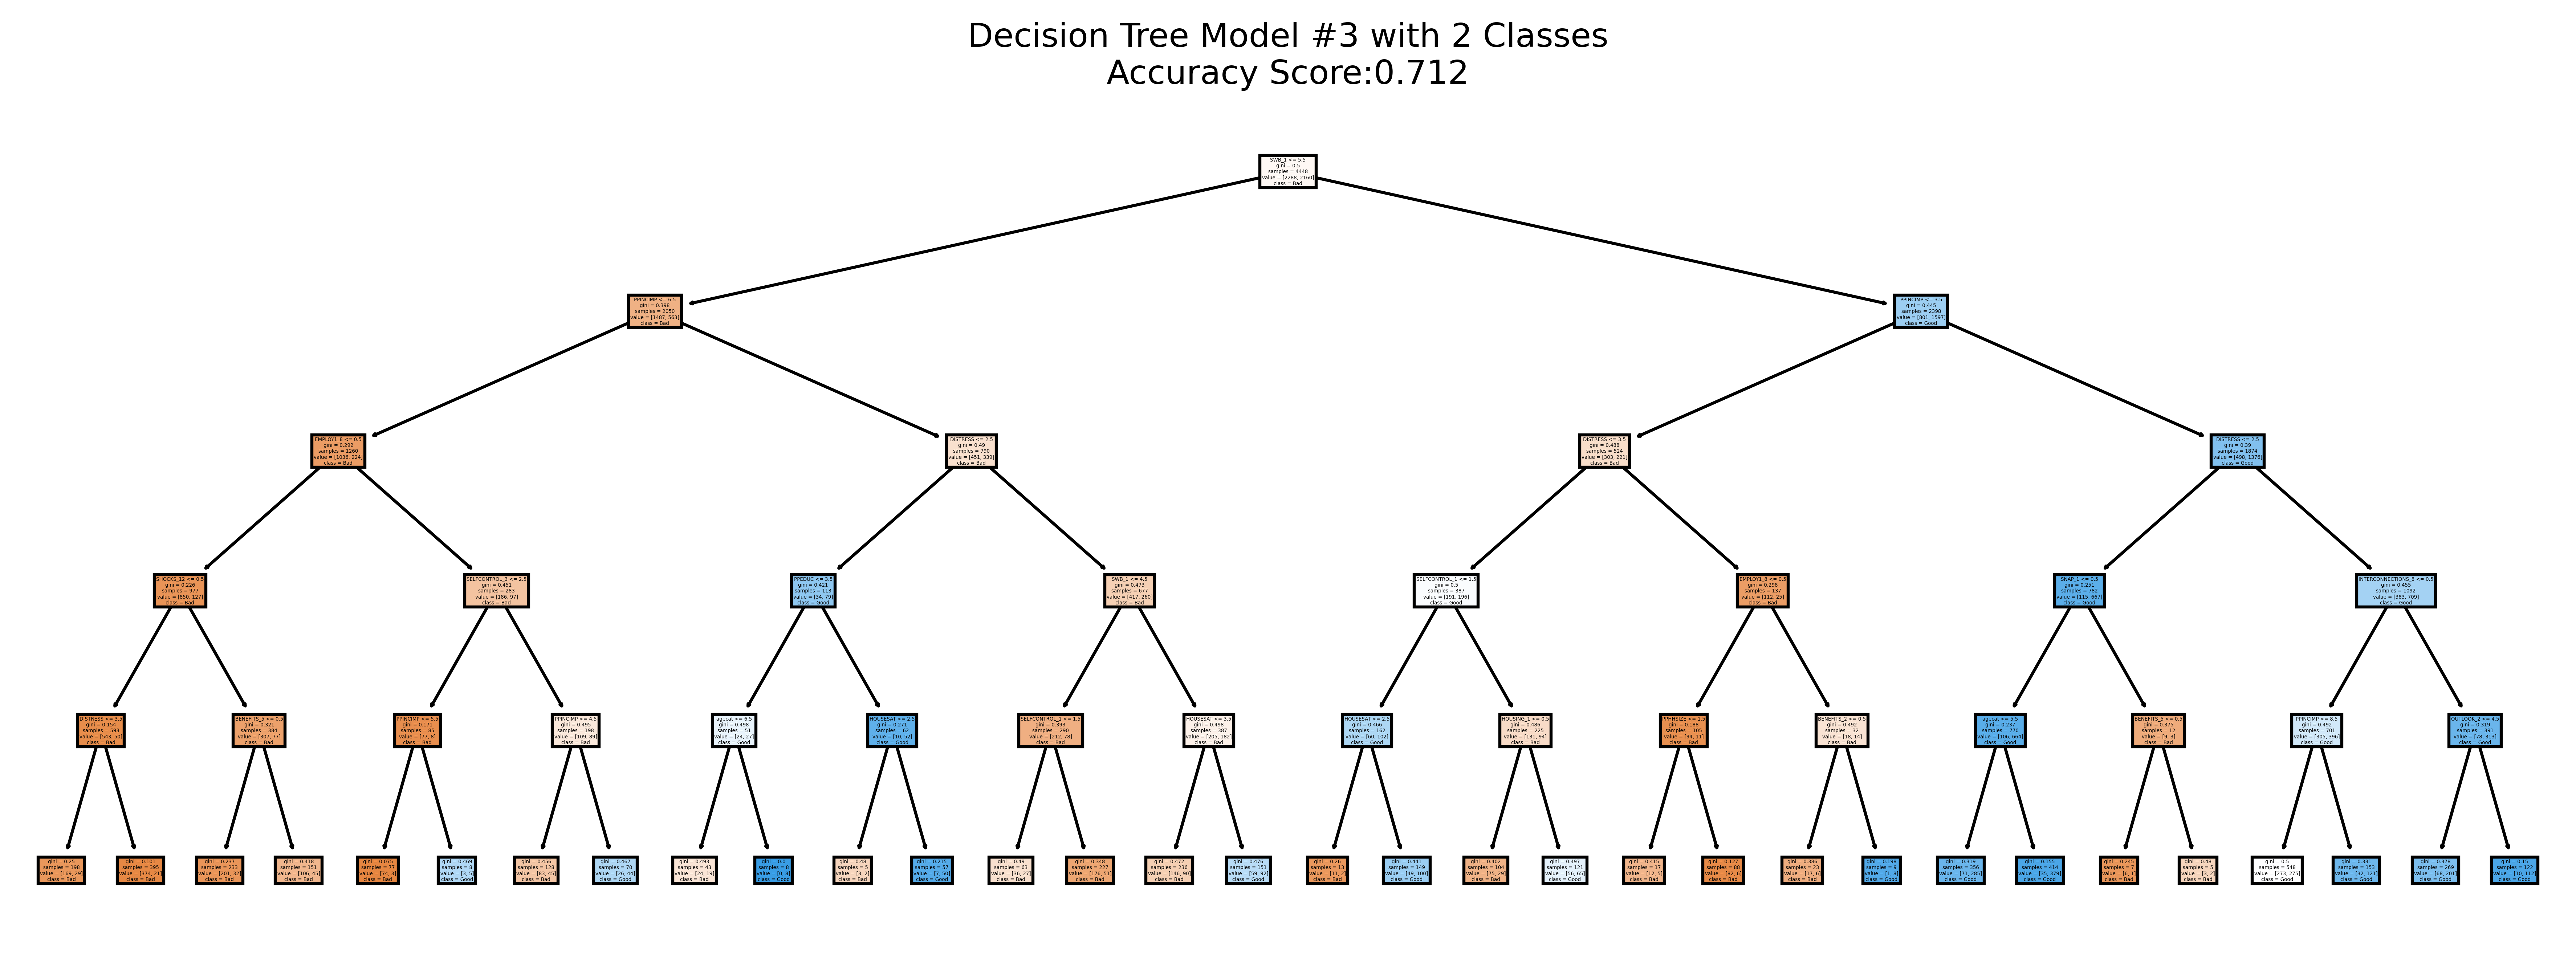

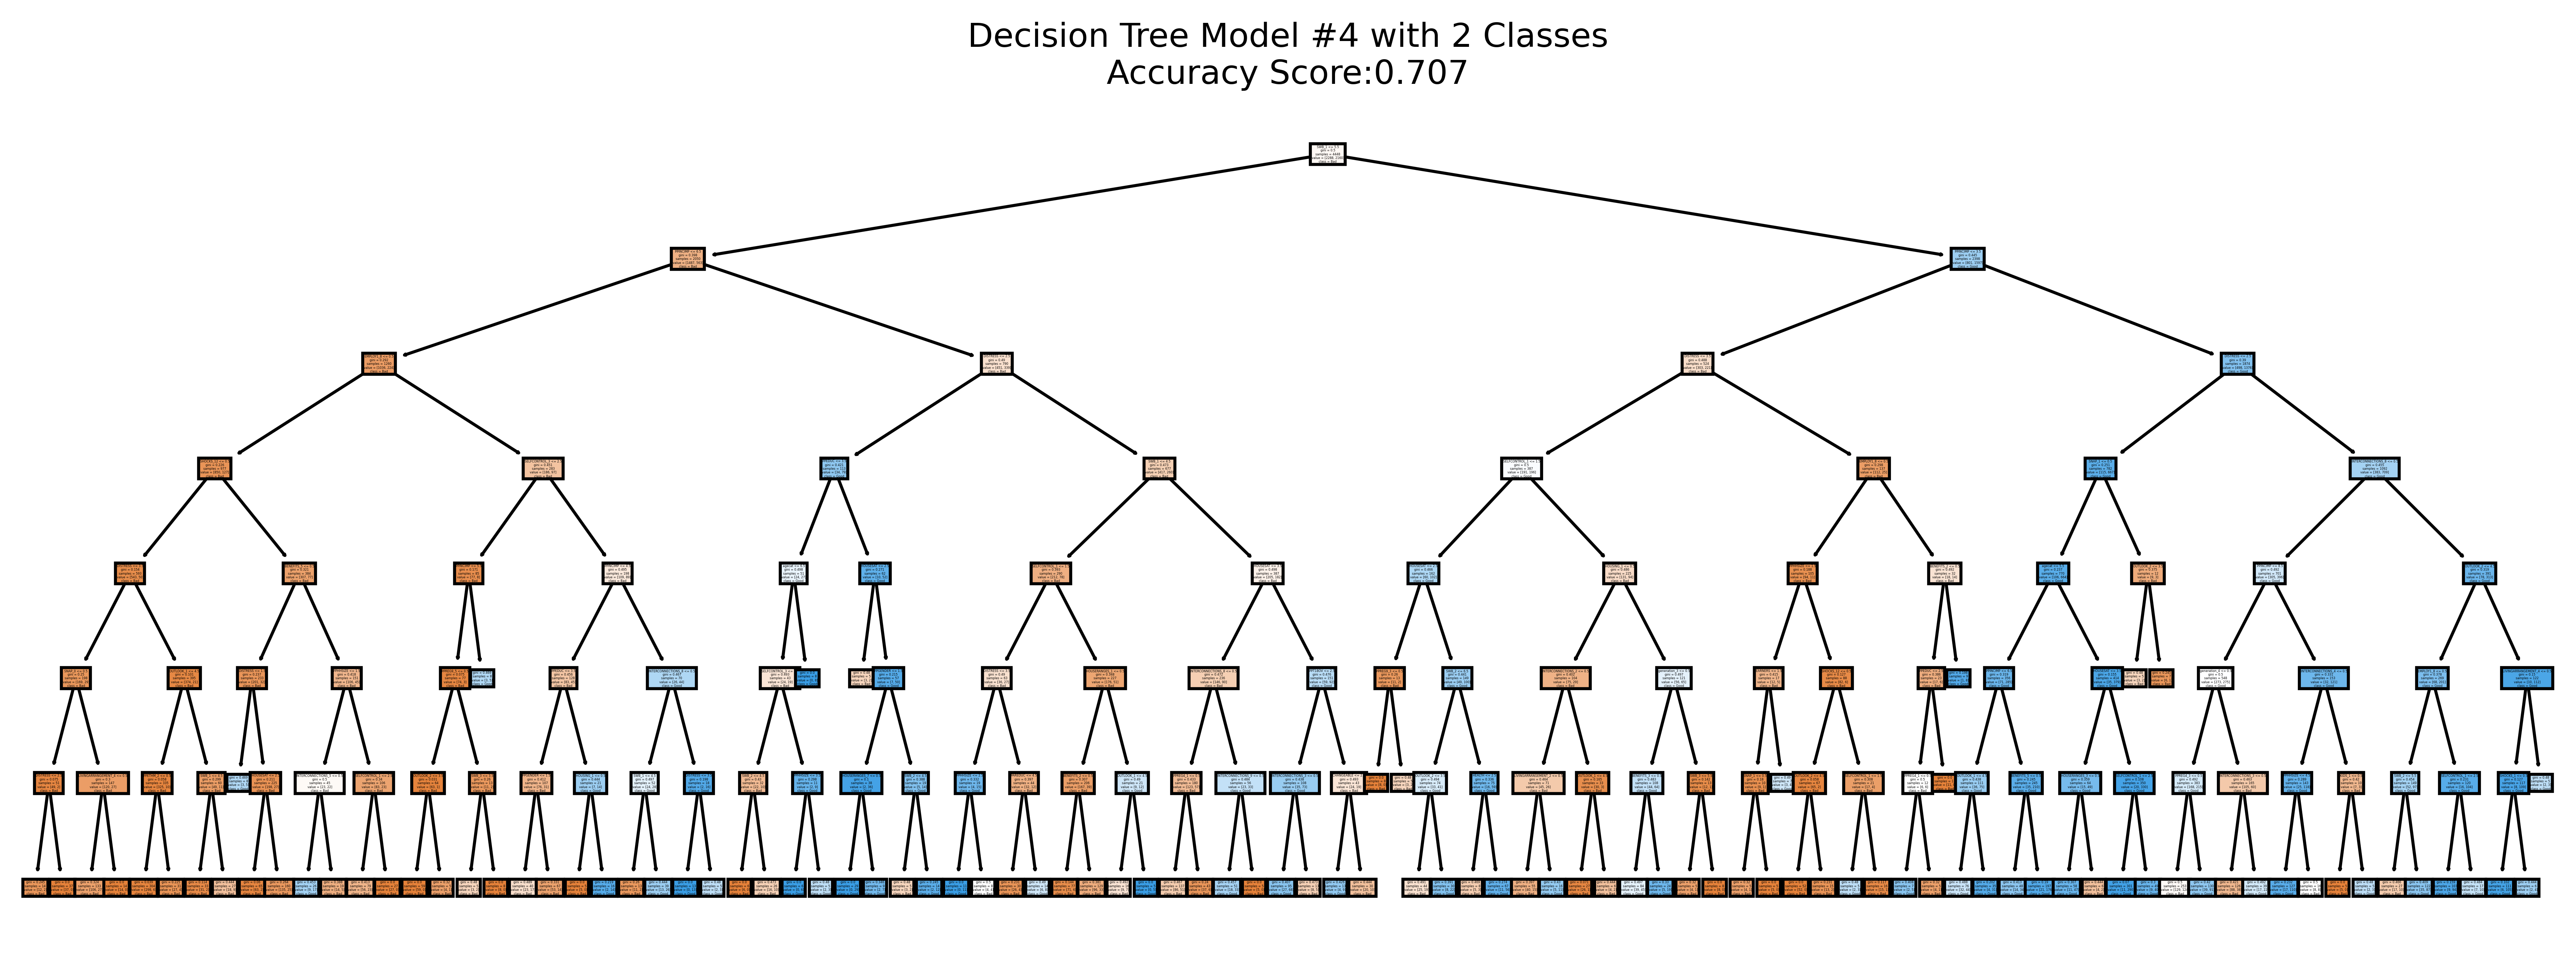

In [24]:
# Plot trees for each model
for i in range(0, len(model_dt2c)):
    plot_d_tree(model_dt2c[i], acc_score_dt2c[i], i, num_classes, figsize)

In [ ]:
# Plot one tree
i = 1
figsize=(15,5)
plot_d_tree(model_dt2c[i], acc_score_dt2c[i], i, num_classes, figsize)

## Random Forest with 2 Target Classes

### Determine the best set of hyperparameters

In [ ]:
# Create random grid with parameters
# Resource: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

parameters = {'n_estimators': [200, 250, 300, 500, 800, 1000, 1500, 2000],
               'max_depth': [5, 8, 10, 15, 20, 50],
               'min_samples_split': [2, 3, 5, 7, 10, 20],
               'min_samples_leaf': [1, 2, 4, 6],
               'bootstrap': [True, False]}

In [ ]:
# Create the RF classifier instance
model_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions = parameters, cv = 5, verbose = True)

In [ ]:
# Fit the model
model_rf = model_rf.fit(X_train, y_train)

In [ ]:
model_rf.best_estimator_

### Fit, Predict and Evaluate Model

In [ ]:
# Create list to store decision tree classifier instances
model_rf2c = []

# RF Model #1 
model_rf2c.append(RandomForestClassifier(n_estimators=200, random_state=78, bootstrap=True,
                                         max_depth=5, min_samples_split=2, min_samples_leaf=1))

# RF Model #2
model_rf2c.append(RandomForestClassifier(n_estimators=500, random_state=78, bootstrap=False,
                                         max_depth=10, min_samples_split=5, min_samples_leaf=3))                 
                  
# RF Model #3: One of the best estimators from RandomizedSearchCV
model_rf2c.append(RandomForestClassifier(n_estimators=800, random_state=78, bootstrap=False,
                                         max_depth=70, min_samples_split=5, min_samples_leaf=4))

In [ ]:
# Create list to store accurancy scores
acc_score_rf2c = []

# Loop to fit, predict and evaluate models
for i in range(0, len(model_rf2c)):
    model = model_rf2c[i]           
               
    # Fit the model
    model = model.fit(X_train, y_train)

    # Make predictions using the testing data
    predictions = model.predict(X_test)
    
    # Evaluate the model and save accuracy score
    print(f'Evaluation of Model #{i+1}\n')
    acc_score = eval_model_cmcr()
    acc_score_rf2c.append(acc_score)

### Plot and Save Images of Sample Trees

In [ ]:
feature_names = list(X.columns)
figsize = (20, 20)

In [ ]:
# Plot trees for each forest
for i in range(0, len(model_rf2c)):
    plot_r_forest(model_rf2c[i], acc_score_rf2c[i], i, num_classes, figsize)

In [ ]:
# Plot trees for one forest
i = 1
figsize = (20, 20)

plot_r_forest(model_rf2c[i], acc_score_rf2c[i], i, num_classes, figsize)

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
# Loop through models to display features sorted by importance hight to low
for i in range(0, len(model_rf2c)):
    model = model_rf2c[i]
    importances = model.feature_importances_
    
    # Sort features by their importance for current model
    pprint(f'Feature Importance for Model #{i+1}')
    pprint(sorted(zip(model.feature_importances_[0:15], X.columns[0:15]), reverse=True))
    print('\n')

## Decision Tree with 3 Target Classes

### Setup and scale data

In [ ]:
# Display quartiles for cutting
data_df['FWBscore'].quantile([.25, .5, .75])

In [ ]:
# Create 3 target classes
num_classes = 3
class_labels = ['<Avg', 'Avg', '>Avg']
y = classify_y(num_classes, class_labels)

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Determine the best set of hyperparameters

In [ ]:
parameters = {'max_depth': (3, 5, 7, 9, 10, 20, 50),
              'max_features': ('sqrt', 'log2', None),
              'min_samples_split': (2, 4, 6, 10, 20, 30),
              'min_samples_leaf': (1, 2, 5, 8) 
             }

In [ ]:
# Create the decision tree classifier instance
model_dt = RandomizedSearchCV(DecisionTreeClassifier(),param_distributions = parameters, cv = 20, verbose = True)

In [ ]:
# Fit the model
model_dt = model_dt.fit(X_train, y_train)

In [ ]:
model_dt.best_estimator_

### Fit, Predict and Evaluate Model

In [ ]:
# Create list to store decision tree classifier instances
model_dt3c = []

# DT Model #1: Default settings
model_dt3c.append(DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_split=2, min_samples_leaf=1))

# DT Model #1: Simple tree
model_dt3c.append(DecisionTreeClassifier(max_depth=3, max_features=None, min_samples_split=5, min_samples_leaf=3))  

# DT Model #3: Best results after testing
model_dt3c.append(DecisionTreeClassifier(max_depth=5, max_features=None, min_samples_split=10, min_samples_leaf=5))                 
                  
# DT Model #4: Best estimator from RandomizedSearchCV
model_dt3c.append(DecisionTreeClassifier(max_depth=7, max_features=None, min_samples_split=4, min_samples_leaf=2))

In [ ]:
# Create list to store accurancy scores
acc_score_dt3c = []

# Loop to Fit, predict and evaluate models
for i in range(0, len(model_dt3c)):
    model = model_dt3c[i]           
               
    # Fit the model
    model = model.fit(X_train, y_train)

    # Make predictions using the testing data
    predictions = model.predict(X_test)
    
    # Evaluate the model and store accuracy score
    print(f'Evaluation of Model #{i+1}\n')
    acc_score = eval_model_cmcr()
    acc_score_dt3c.append(acc_score)

### Plot and Save Decision Trees

In [ ]:
feature_names = list(X.columns)
figsize = (15,5)

In [ ]:
# Plot trees for each model
for i in range(0, len(model_dt2c)):
    plot_d_tree(model_dt2c[i], acc_score_dt2c[i], i, num_classes, figsize)

In [ ]:
# Plot one tree
i = 1
figsize=(15,5)
plot_d_tree(model_dt2c[i], acc_score_dt2c[i], i, num_classes, figsize)

## Random Forest with 3 Target Classes

### Determine the best set of hyperparameters

In [ ]:
# Create random grid with parameters
# Resource: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

parameters = {'n_estimators': [200, 250, 300, 500, 800, 1000, 1500, 2000],
               'max_depth': [5, 8, 10, 15, 20, 50],
               'min_samples_split': [2, 3, 5, 7, 10, 20],
               'min_samples_leaf': [1, 2, 4, 6],
               'bootstrap': [True, False]}

In [ ]:
# Create the RF classifier instance
model_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions = parameters, cv = 5, verbose = True)

In [ ]:
# Fit the model
model_rf = model_rf.fit(X_train, y_train)

In [ ]:
model_rf.best_estimator_

### Fit, Predict and Evaluate Model

In [ ]:
# Create list to store decision tree classifier instances
model_rf3c = []

# RF Model #1 
model_rf3c.append(RandomForestClassifier(n_estimators=200, random_state=78, bootstrap=True,
                                         max_depth=5, min_samples_split=2, min_samples_leaf=1))

# RF Model #2
model_rf3c.append(RandomForestClassifier(n_estimators=500, random_state=78, bootstrap=False,
                                         max_depth=10, min_samples_split=5, min_samples_leaf=3))                 
                  
# RF Model #3: One of the best estimators from RandomizedSearchCV
model_rf3c.append(RandomForestClassifier(n_estimators=800, random_state=78, bootstrap=False,
                                         max_depth=70, min_samples_split=5, min_samples_leaf=4))

In [ ]:
# Create list to store accurancy scores
acc_score_rf23 = []

# Loop to fit, predict and evaluate models
for i in range(0, len(model_rf3c)):
    model = model_rf3c[i]           
               
    # Fit the model
    model = model.fit(X_train, y_train)

    # Make predictions using the testing data
    predictions = model.predict(X_test)
    
    # Evaluate the model and save accuracy score
    print(f'Evaluation of Model #{i+1}\n')
    acc_score = eval_model_cmcr()
    acc_score_rf3c.append(acc_score)

### Plot and Save Images of Sample Trees

In [ ]:
feature_names = list(X.columns)
figsize = (20, 20)

In [ ]:
# Plot 4 trees for each forest
for i in range(0, len(model_rf3c)):
    plot_r_forest(model_rf3c[i], acc_score_rf3c[i], i, num_classes, figsize)

In [ ]:
# Plot 4 trees for one forest
i = 1
figsize = (20, 20)

plot_r_forest(model_rf3c[i], acc_score_rf3c[i], i, num_classes, figsize)

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
# Loop through models to display features sorted by importance hight to low
for i in range(0, len(model_rf2c)):
    model = model_rf2c[i]
    importances = model.feature_importances_
    
    # Sort features by their importance for current model
    pprint(f'Feature importance for model #{i+1}')
    pprint(sorted(zip(model.feature_importances_[0:15], X.columns[0:15]), reverse=True))
    print('\n')